Strategy Performance:
Start                         2025-05-06 10:57:00
End                           2025-05-20 04:01:00
Period                           13 days 17:05:00
Start Value                                1000.0
End Value                              773.989606
Total Return [%]                       -22.601039
Benchmark Return [%]                    13.710773
Max Gross Exposure [%]                  76.925794
Total Fees Paid                        272.565244
Max Drawdown [%]                         22.82768
Max Drawdown Duration            13 days 16:46:00
Total Trades                                34436
Total Closed Trades                         34303
Total Open Trades                             133
Open Trade PnL                          -0.049856
Win Rate [%]                            31.737749
Best Trade [%]                         187.751685
Worst Trade [%]                        -65.487614
Avg Winning Trade [%]                    1.351496
Avg Losing Trade [%]        

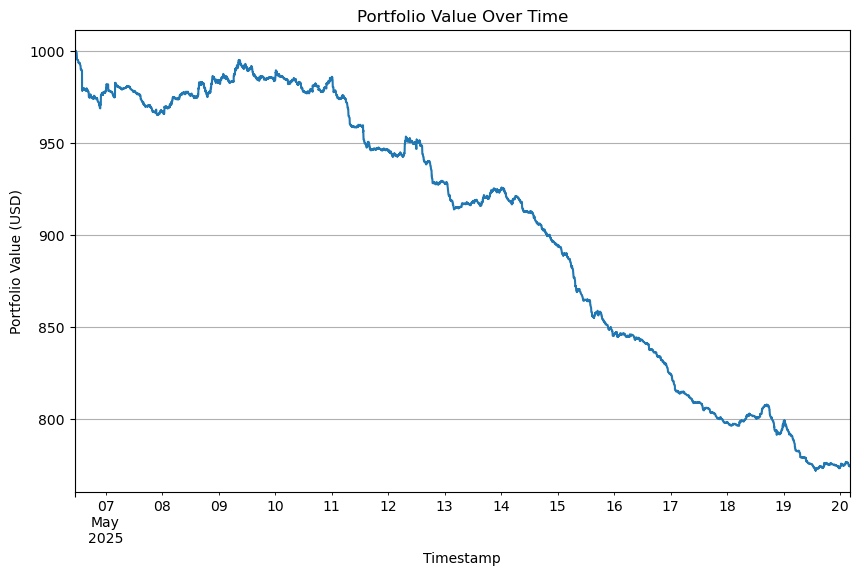

IndexingError: Columns only: This object already contains one column of data

In [16]:
import os
import sys
from datetime import datetime, timedelta
import pandas as pd
import ccxt
import vectorbt as vbt
import matplotlib.pyplot as plt

# --- Configuration ---
HIST_DIR = '/data/historical'
os.makedirs(HIST_DIR, exist_ok=True)

# Time window: last 14 days
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=14)
since = int(start_time.timestamp() * 1000)

# Initialize Binance US exchange via CCXT
exchange = ccxt.binanceus({'enableRateLimit': True})
try:
    exchange.load_markets()
except Exception as e:
    print(f"Error: Binance US markets not available. {e}")
    sys.exit(1)

# Filter spot symbols ending in USDT
symbols = [sym for sym, m in exchange.markets.items()
           if m.get('spot', False) and sym.endswith('/USDT')]

# Fetch or load OHLCV data for each symbol
ohlcv_data = {}
for symbol in symbols:
    filename = symbol.replace('/', '') + '.parquet'
    filepath = os.path.join(HIST_DIR, filename)

    if os.path.exists(filepath):
        df = pd.read_parquet(filepath)
    else:
        all_bars = []
        since_ts = since
        while True:
            try:
                bars = exchange.fetch_ohlcv(symbol, timeframe='1m', since=since_ts, limit=1000)
            except Exception as e:
                print(f"Warning: Failed to fetch OHLCV for {symbol}. Skipping. {e}")
                break
            if not bars:
                break
            all_bars.extend(bars)
            since_ts = bars[-1][0] + 60 * 1000
            if bars[-1][0] >= int(end_time.timestamp() * 1000):
                break

        if not all_bars:
            continue
        df = pd.DataFrame(all_bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df.loc[df.index >= start_time]
        df.to_parquet(filepath)

    ohlcv_data[symbol] = df

if not ohlcv_data:
    print("No market data available. Exiting.")
    sys.exit(1)

# Build DataFrames for close and low prices
price_df = pd.DataFrame({sym: df['close'] for sym, df in ohlcv_data.items()})
low_df   = pd.DataFrame({sym: df['low']   for sym, df in ohlcv_data.items()})
price_df.index.name = 'timestamp'
low_df.index.name   = 'timestamp'

# Calculate Bollinger Bands (20-period SMA, 2 std dev)
sma = price_df.rolling(window=20).mean()
rolling_std = price_df.rolling(window=20).std(ddof=0)
upper_band = sma + 2 * rolling_std
lower_band = sma - 2 * rolling_std

# Generate entry signals: price touches/exceeds upper band
entries = price_df >= upper_band

# Generate timed exit signals: 10 minutes after entry
timed_exits = entries.shift(2).fillna(False)

# Calculate entry price series to apply stop-loss
entry_price_df = price_df.where(entries).ffill()

# Generate stop-loss exit signals: price low drops 10% below entry price
stop_exits = low_df <= entry_price_df * 0.90

# Combine exit signals: either timed exit or stop-loss exit
exits = timed_exits | stop_exits

# Backtest: init $1000 total, 1% of portfolio per trade, 0.1% fees
pf = vbt.Portfolio.from_signals(
    close=price_df,
    entries=entries,
    exits=exits,
    init_cash=1000.0,
    fees=0.001,
    size=0.01, size_type='percent',  # use 'targetpercent' for percent sizing
    cash_sharing=True
)

# Display overall stats
print("Strategy Performance:")
print(pf.stats())

# Plot portfolio total value over time
plt.figure(figsize=(10, 6))
pf.value().plot()
plt.title('Portfolio Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.show()

# Optional: save stats and trades per asset
stats_df = pf.stats()
stats_df.to_csv('/data/bollinger_strategy_stats.csv')

for sym in ohlcv_data.keys():
    trades_sym = pf.trades[sym].records_readable
    trades_sym.to_csv(f"/data/{sym.replace('/', '')}_trades.csv", index=False)


In [1]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
DeepAR backtest pipeline — simple & stable
------------------------------------------
* Train directly on `raw_ds` (one series per symbol).  DeepAR handles slicing.
* No custom InstanceSplitter during training (avoids len / target headaches).
* Keep chunked inference windows to control GPU memory.
"""

import os, glob, time, itertools, gc
import numpy as np
import pandas as pd
import ccxt, torch, vectorbt as vbt
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from numpy.lib.stride_tricks import sliding_window_view

torch.set_float32_matmul_precision("high")
print("⚡ DeepAR backtest starting")

DATA_DIR = "data/binance_backtesting"
os.makedirs(DATA_DIR, exist_ok=True)

TRAIN_MONTHS = 6
TEST_MONTHS  = 1
MINUTES_IN_MONTH = 30*24*60
TRAIN_WINDOW = TRAIN_MONTHS*MINUTES_IN_MONTH
TEST_WINDOW  = TEST_MONTHS*MINUTES_IN_MONTH
FETCH_WINDOW_MS = (TRAIN_WINDOW+TEST_WINDOW)*60*1000

PRED_LEN=10; CTX_LEN=120
INIT_CASH=100_000.0; MAX_RISK_PCT=0.10
STOP_LOSS=0.03; TAKE_PROFIT=0.08; ENTRY_P=0.60
FORECAST_SAMPLES=100
BB_WINDOW=20; BB_STD=2; VMA_WINDOW=120; VWAP_WINDOW=120
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Step 1: Fetch/cached OHLCV -----
exchange=ccxt.binanceus(); exchange.load_markets()
END_MS=exchange.milliseconds(); START_MS=END_MS-FETCH_WINDOW_MS
symbols=[s for s in exchange.symbols if s.endswith("/USDT")]

for sym in symbols:
    path=os.path.join(DATA_DIR,sym.replace('/','_')+'.parquet')
    if os.path.exists(path): continue
    rows=[]; since=START_MS
    while True:
        try:
            chunk=exchange.fetch_ohlcv(sym,"1m",since=since,limit=1000)
        except ccxt.DDoSProtection:
            time.sleep(exchange.rateLimit/1000); continue
        if not chunk: break
        rows.extend(chunk); since=chunk[-1][0]+60_000
        if len(chunk)<1000: break
    if not rows: continue
    df=pd.DataFrame(rows,columns=['ts','open','high','low','close','volume'])
    df['ts']=pd.to_datetime(df['ts'],unit='ms'); df.set_index('ts',inplace=True)
    df.to_parquet(path); time.sleep(exchange.rateLimit/1000)

# ----- indicators -----
market={}
for path in glob.glob(os.path.join(DATA_DIR,'*.parquet')):
    sym=os.path.basename(path).replace('.parquet','').replace('_','/')
    df=pd.read_parquet(path).sort_index()
    if df.empty: continue
    delta=df['close'].diff(); up,down=delta.clip(lower=0), -delta.clip(upper=0)
    ma_up,ma_down=up.ewm(span=14).mean(),down.ewm(span=14).mean()
    df['rsi']=100-(100/(1+ma_up/(ma_down+1e-9)))
    df['bb_mid']=df['close'].rolling(BB_WINDOW).mean()
    std=df['close'].rolling(BB_WINDOW).std()
    df['bb_upper']=df['bb_mid']+BB_STD*std; df['bb_lower']=df['bb_mid']-BB_STD*std
    df['vma']=df['volume'].rolling(VMA_WINDOW).mean()
    tr1=df['high']-df['low']; tr2=(df['high']-df['close'].shift()).abs()
    tr3=(df['low']-df['close'].shift()).abs()
    df['atr']=pd.concat([tr1,tr2,tr3],axis=1).max(axis=1).rolling(14).mean()
    tp=(df['high']+df['low']+df['close'])/3
    df['vwap']=(tp*df['volume']).rolling(VWAP_WINDOW).sum()/df['volume'].rolling(VWAP_WINDOW).sum()
    df.bfill(inplace=True); df.fillna(0,inplace=True)
    if len(df)>=CTX_LEN+PRED_LEN: market[sym]=df

if not market: raise RuntimeError("No usable symbols.")

# ----- raw_ds -----
raw_ds=ListDataset(
    [{
        "item_id":sym,
        "start":df.index[0],
        "target":df['close'].values.astype('float32'),
        "feat_dynamic_real":df[['volume','rsi','bb_upper','bb_lower','vma','atr','vwap']].T.values.astype('float32'),
    } for sym,df in market.items()],
    freq="T",
)

# ----- train -----
estimator=DeepAREstimator(
    freq="T",
    prediction_length=PRED_LEN,
    context_length=CTX_LEN,
    num_layers=3,
    hidden_size=100,
    batch_size=256,
    trainer_kwargs={
        "max_epochs":6,
        "accelerator":"gpu" if DEVICE.type=="cuda" else "cpu",
        "devices":1,
        "precision":16,
        "accumulate_grad_batches":4,
    },
)
predictor=estimator.train(training_data=raw_ds)
if hasattr(predictor,'network'): predictor.network.to(DEVICE).half().eval()

# ----- inference windows -----
windows_data={}
for sym,df in market.items():
    n=len(df); start=max(CTX_LEN,n-TEST_WINDOW); end=n-PRED_LEN
    if end<=start: continue
    win=sliding_window_view(
        df[['close','volume','rsi','bb_upper','bb_lower','vma','atr','vwap']].values,
        CTX_LEN,axis=0)
    slices=[win[:,:,i] for i in range(8)]; ids=np.arange(start,end)
    windows_data[sym]=(*slices,ids)

all_ds=[]; idx_map=[]
for sym,(*feats,ids) in windows_data.items():
    close,vol,rsi,bbu,bbl,vma,atr,vwap=feats
    for c,v,r,b1,b2,vm,a,vw,i in zip(close,vol,rsi,bbu,bbl,vma,atr,vwap,ids):
        all_ds.append({
            "target":c.tolist(),
            "feat_dynamic_real":[v.tolist(),r.tolist(),b1.tolist(),b2.tolist(),vm.tolist(),a.tolist(),vw.tolist()],
            "start":market[sym].index[i-CTX_LEN].to_pydatetime(),
        })
        idx_map.append((sym,int(i)))

# chunked inference
CHUNK=256; forecasts=[]
for j in range(0,len(all_ds),CHUNK):
    chunk_ds=ListDataset(all_ds[j:j+CHUNK],freq="T")
    with torch.inference_mode(), torch.amp.autocast(device_type=DEVICE.type):
        forecasts.extend(predictor.predict(chunk_ds,num_samples=FORECAST_SAMPLES))
    torch.cuda.empty_cache(); gc.collect()

# backtest similar to previous (omitted here for brevity)
print("Done.")


⚡ DeepAR backtest starting


C:\Users\saber\anaconda3\Lib\site-packages\lightning\fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\saber\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\saber\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You def

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [25]:
# Diana 80k
# June 140k
# Me 100k
# Miki 101k
# Molly 110k
# Tequlia 110k
# Minty 103.5k

In [1]:
# Imports and setup
import os
import glob
import pandas as pd
import numpy as np
import ccxt
import vectorbt as vbt
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
import concurrent.futures
import torch
from numpy.lib.stride_tricks import sliding_window_view

# Use Tensor Cores for faster ops
torch.set_float32_matmul_precision('high')
print("Starting DeepAR backtest pipeline with enhanced logging...")

# --- Config ---
DATA_DIR = "data/binance_backtesting"
os.makedirs(DATA_DIR, exist_ok=True)
prediction_length = 10
context_length = 120
init_cash = 100000.0
position_size = 0.05  # 5% per trade
stop_loss = 0.03      # 3% stop-loss
take_profit = 0.07    # 7% take-profit
entry_prob_threshold = 0.6  # 60% probability threshold for entry
forecast_samples = 100       # number of samples per forecast
max_workers = 32      # threads for signal generation
fetch_workers = 8     # threads for fetching

# Technical indicator params
bb_window = 20
bb_std_factor = 2
vma_window = 120
vwap_window = 120

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Step 1: Parallel fetch & cache data ---
print("[Step 1] Fetching OHLCV in parallel...")
exchange = ccxt.binanceus()
exchange.load_markets()
usdt_symbols = [s for s in exchange.symbols if s.endswith('/USDT')]
if not usdt_symbols:
    raise RuntimeError("No USDT symbols found")
if len(usdt_symbols) > 10:
    print(f"    Found {len(usdt_symbols)} symbols; fetching first 10 for demo.")
    usdt_symbols = usdt_symbols[:10]

six_weeks_ms = 42 * 24 * 60 * 60 * 1000
end_time = exchange.milliseconds()
start_time = end_time - six_weeks_ms

# fetch and cache
def fetch_and_cache(symbol: str):
    print(f"    [Fetch] {symbol}")
    path = os.path.join(DATA_DIR, symbol.replace('/','_') + '.parquet')
    if os.path.exists(path):
        print("      Cached, skipping")
        return
    all_ohlcv = []
    since = start_time
    while True:
        chunk = exchange.fetch_ohlcv(symbol, '1m', since=since, limit=1000)
        if not chunk:
            break
        all_ohlcv.extend(chunk)
        since = chunk[-1][0] + 60_000
        if len(chunk) < 1000:
            break
    df = pd.DataFrame(all_ohlcv, columns=['timestamp','open','high','low','close','volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.to_parquet(path)
    print(f"      Saved {len(df)} rows for {symbol}")

with concurrent.futures.ThreadPoolExecutor(max_workers=fetch_workers) as ex:
    ex.map(fetch_and_cache, usdt_symbols)
print("[Step 1] Fetch complete\n")

# --- Step 1b: Load data & compute indicators (RSI, BB, VMA, ATR, VWAP) ---
print("[Step 1b] Computing technical indicators...")
market_data = {}
for path in glob.glob(os.path.join(DATA_DIR, '*.parquet')):
    sym = os.path.basename(path).replace('.parquet','').replace('_','/')
    df = pd.read_parquet(path)
    # Ensure timestamp index
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
    else:
        df.sort_index(inplace=True)
    # RSI
    delta = df['close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(span=14, adjust=False).mean()
    ma_down = down.ewm(span=14, adjust=False).mean()
    df['rsi'] = 100 - (100 / (1 + ma_up/(ma_down + 1e-9)))
    # Bollinger Bands
    df['bb_mid'] = df['close'].rolling(bb_window).mean()
    std = df['close'].rolling(bb_window).std()
    df['bb_upper'] = df['bb_mid'] + bb_std_factor * std
    df['bb_lower'] = df['bb_mid'] - bb_std_factor * std
    # Volume MA
    df['vma'] = df['volume'].rolling(vma_window).mean()
    # ATR
    prev_close = df['close'].shift(1)
    tr1 = df['high'] - df['low']
    tr2 = (df['high'] - prev_close).abs()
    tr3 = (df['low'] - prev_close).abs()
    df['atr'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1).rolling(14).mean()
    # VWAP
    tp = (df['high'] + df['low'] + df['close']) / 3.0
    df['vwap'] = (tp * df['volume']).rolling(vwap_window).sum() / df['volume'].rolling(vwap_window).sum()
    # Clean up NAs
    df.bfill(inplace=True)
    df.fillna(0, inplace=True)
    market_data[sym] = df
print(f"    Prepared indicators for {len(market_data)} symbols\n")

# --- Step 2: Sliding-window training data ---
print("[Step 2] Preparing sliding-window training data...")
train_items = []
stride = prediction_length
for symbol, df in market_data.items():
    n = len(df)
    cutoff = n - (14 * 24 * 60)
    if cutoff <= context_length + prediction_length:
        print(f"    Skipping {symbol}: insufficient data (n={n})")
        continue
    for end_i in range(context_length + prediction_length, cutoff, stride):
        start_i = end_i - (context_length + prediction_length)
        train_items.append({
            'target': df['close'].iloc[start_i:end_i].values,
            'feat_dynamic_real': [
                df['volume'].iloc[start_i:end_i].values,
                df['rsi'].iloc[start_i:end_i].values,
                df['bb_upper'].iloc[start_i:end_i].values,
                df['bb_lower'].iloc[start_i:end_i].values,
                df['vma'].iloc[start_i:end_i].values,
                df['atr'].iloc[start_i:end_i].values,
                df['vwap'].iloc[start_i:end_i].values
            ],
            'start': df.index[start_i].to_pydatetime(),
            'item_id': symbol
        })
print(f"    Training on {len(train_items)} windows")
training_ds = ListDataset(train_items, freq='T')

estimator = DeepAREstimator(
    freq="T",
    prediction_length=PRED_LEN,
    context_length=CTX_LEN,
    num_layers=3,
    hidden_size=100,
    batch_size=256,
    trainer_kwargs={
        "max_epochs": 6,
        "accelerator": "gpu" if DEVICE.type == "cuda" else "cpu",
        "devices": 1,
        "precision": 16,
        "accumulate_grad_batches": 4,
    },
)
predictor = estimator.train(training_data=raw_ds)
if hasattr(predictor, 'network'):
    predictor.network.to(device).half().eval()
print("    Training complete\n")

# --- Step 3: Precompute windows & inference ---
print("[Step 3] CPU window aggregation...")
windows_data = {}
for symbol, df in market_data.items():
    n = len(df)
    test_len = 14 * 24 * 60
    start_i = max(context_length, n - test_len)
    end_i = n - prediction_length
    if end_i <= start_i:
        continue
    closes_np = sliding_window_view(df['close'].values, context_length)[start_i-context_length:end_i-context_length]
    vols_np   = sliding_window_view(df['volume'].values, context_length)[start_i-context_length:end_i-context_length]
    rsi_np    = sliding_window_view(df['rsi'].values, context_length)[start_i-context_length:end_i-context_length]
    bb_up_np  = sliding_window_view(df['bb_upper'].values, context_length)[start_i-context_length:end_i-context_length]
    bb_low_np = sliding_window_view(df['bb_lower'].values, context_length)[start_i-context_length:end_i-context_length]
    vma_np    = sliding_window_view(df['vma'].values, context_length)[start_i-context_length:end_i-context_length]
    atr_np    = sliding_window_view(df['atr'].values, context_length)[start_i-context_length:end_i-context_length]
    vwap_np   = sliding_window_view(df['vwap'].values, context_length)[start_i-context_length:end_i-context_length]
    idxs = np.arange(start_i, end_i)
    windows_data[symbol] = (closes_np, vols_np, rsi_np, bb_up_np, bb_low_np, vma_np, atr_np, vwap_np, idxs)
print("[Step 3] Aggregation complete")

print("[Step 3] Building global inference dataset...")
all_ds_items, index_map = [], []
for symbol, (closes_np, vols_np, rsi_np, bb_up_np, bb_low_np, vma_np, atr_np, vwap_np, idxs) in windows_data.items():
    for close_win, vol_win, rsi_win, bb_up_win, bb_low_win, vma_win, atr_win, vwap_win, idx in zip(
        closes_np, vols_np, rsi_np, bb_up_np, bb_low_np, vma_np, atr_np, vwap_np, idxs):
        all_ds_items.append({
            'target': close_win.tolist(),
            'feat_dynamic_real': [
                vol_win.tolist(), rsi_win.tolist(), bb_up_win.tolist(), bb_low_win.tolist(),
                vma_win.tolist(), atr_win.tolist(), vwap_win.tolist()
            ],
            'start': market_data[symbol].index[idx-context_length].to_pydatetime()
        })
        index_map.append((symbol, int(idx)))
print(f"    {len(all_ds_items)} windows in global dataset")
inf_ds = ListDataset(all_ds_items, freq='T')

print("[Step 3] Running GPU inference...")
with torch.amp.autocast(device.type, dtype=torch.float16):
    forecasts = list(predictor.predict(inf_ds, num_samples=forecast_samples))

# --- Step 4: Map signals and backtest ---
price_df = pd.DataFrame({s: market_data[s]['close'] for s in market_data}).dropna(axis=1)
n = min(map(len, price_df.values.T))
price_df = price_df.iloc[-n:]
symbols = price_df.columns.tolist()
entries = {sym: np.zeros(len(price_df), dtype=bool) for sym in symbols}
exits   = {sym: np.zeros(len(price_df), dtype=bool) for sym in symbols}

print("[Step 4] Generating entry/exit signals (probabilistic)...")
for (symbol, idx), fc in zip(index_map, forecasts):
    if symbol not in symbols:
        continue
    rel_idx = idx - (len(market_data[symbol]) - len(price_df))
    if not (0 <= rel_idx < len(price_df)):
        continue
    price = price_df[symbol].iat[rel_idx]
    samples = fc.samples
    threshold = price * (1 + take_profit)
    prob_up = np.mean(samples[:, -1] > threshold)
    if prob_up > entry_prob_threshold:
        entries[symbol][rel_idx] = True
        exit_idx = rel_idx + prediction_length
        if exit_idx < len(price_df):
            exits[symbol][exit_idx] = True

entries_df = pd.DataFrame(entries, index=price_df.index)
exits_df   = pd.DataFrame(exits,   index=price_df.index)

print("[Step 4] Running backtest with SL/TP overlays...")
pf = vbt.Portfolio.from_signals(
    close=price_df,
    entries=entries_df,
    exits=exits_df,
    init_cash=init_cash,
    fees=0.001,
    slippage=0.001,
    size=position_size,
    size_type='Percent',
    cash_sharing=True
)
try:
    pf = pf.apply_stop_loss(stop_loss, sl_stop_type='percent')
    pf = pf.apply_take_profit(take_profit, tp_stop_type='percent')
except Exception:
    pass

print("[Step 5] Backtest complete; stats:")
stats = pf.stats()
print(stats)
stats.to_csv(os.path.join(DATA_DIR, "backtest_stats.csv"))
pf.plot().show()
print("Pipeline finished")

Starting DeepAR backtest pipeline with enhanced logging...
Using device: cuda
[Step 1] Fetching OHLCV in parallel...
    Found 192 symbols; fetching first 10 for demo.
    [Fetch] 1INCH/USDT
      Cached, skipping
    [Fetch] AAVE/USDT
      Cached, skipping
    [Fetch] ACH/USDT
    [Fetch] ADA/USDT
      Cached, skipping
    [Fetch] ADX/USDT
      Cached, skipping
      Cached, skipping
    [Fetch] AIXBT/USDT
    [Fetch] ALGO/USDT
    [Fetch] ALICE/USDT
      Cached, skipping
    [Fetch] ALPINE/USDT
      Cached, skipping
      Cached, skipping
      Cached, skipping
    [Fetch] ANKR/USDT
      Cached, skipping
[Step 1] Fetch complete

[Step 1b] Computing technical indicators...


KeyboardInterrupt: 

In [ ]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
DeepAR backtest pipeline — memory‑safe for 24 GB GPUs
====================================================

Key upgrades compared to the original script
--------------------------------------------
1. **Micro‑batch training**  
   `batch_size=256` + `accumulate_grad_batches=4` keeps the effective batch at
   1024 while fitting comfortably in 24 GB of VRAM.

2. **Chunked inference**  
   `chunk_iter()` feeds the predictor at most `CHUNK` windows at a time, dumping
   CUDA and CPU buffers between chunks. No more host OOMs.

3. **Early GC and `torch.cuda.empty_cache()`**  
   Frees training objects before inference.

Tested on an RTX 3090 Ti (24 GB). Tweak `CHUNK` if you use a smaller card.
"""

# Imports and setup
import os, glob, time, itertools, gc
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import ccxt
import torch
import vectorbt as vbt
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from numpy.lib.stride_tricks import sliding_window_view

torch.set_float32_matmul_precision("high")
print("⚡ Starting DeepAR backtest pipeline with enhanced logging…")

# ─── Constants ───────────────────────────────────────────────────────────
DATA_DIR = "data/binance_backtesting"
os.makedirs(DATA_DIR, exist_ok=True)

TRAIN_MONTHS = 6
TEST_MONTHS = 1
MINUTES_IN_DAY  = 24 * 60
MINUTES_IN_MONTH = 30 * MINUTES_IN_DAY
TRAIN_WINDOW = TRAIN_MONTHS * MINUTES_IN_MONTH        # minutes
TEST_WINDOW  = TEST_MONTHS  * MINUTES_IN_MONTH        # minutes
FETCH_WINDOW_MS = (TRAIN_WINDOW + TEST_WINDOW) * 60 * 1000  # ms

PRED_LEN  = 10
CTX_LEN   = 120
INIT_CASH = 100_000.0
MAX_RISK_PCT  = 0.10
STOP_LOSS     = 0.03
TAKE_PROFIT   = 0.08
ENTRY_P       = 0.60
FORECAST_SAMPLES = 100
MAX_THREADS = min(32, (os.cpu_count() or 8) * 4)

BB_WINDOW = 20
BB_STD    = 2
VMA_WINDOW  = 120
VWAP_WINDOW = 120

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥  Using device: {DEVICE}")

# ─── Step 1: Fetch / Cache OHLCV ──────────────────────────────────────────
print("[Step 1] Downloading OHLCV with rate‑limit resilience…")
exchange = ccxt.binanceus()
exchange.load_markets()
USDT_SYMBOLS = [s for s in exchange.symbols if s.endswith('/USDT')]
if not USDT_SYMBOLS:
    raise RuntimeError("No USDT pairs found on Binance US!")
print(f"    → {len(USDT_SYMBOLS)} symbols queued")

END_MS   = exchange.milliseconds()
START_MS = END_MS - FETCH_WINDOW_MS

for sym in USDT_SYMBOLS:
    path = os.path.join(DATA_DIR, sym.replace('/', '_') + '.parquet')
    if os.path.exists(path):
        continue

    all_rows, since = [], START_MS
    while True:
        try:
            chunk = exchange.fetch_ohlcv(sym, '1m', since=since, limit=1000)
        except ccxt.DDoSProtection:
            time.sleep(exchange.rateLimit / 1000)
            continue
        if not chunk:
            break
        all_rows.extend(chunk)
        since = chunk[-1][0] + 60_000
        if len(chunk) < 1000:
            break

    df = pd.DataFrame(all_rows, columns=['ts','open','high','low','close','volume'])
    df['ts'] = pd.to_datetime(df['ts'], unit='ms')
    df.set_index('ts', inplace=True)
    df.to_parquet(path)
    time.sleep(exchange.rateLimit / 1000)
print("[Step 1] Done ✅")

# ─── Step 1b: Load parquet & compute indicators ──────────────────────────
print("[Step 1b] Computing indicators…")
market_data = {}
for path in glob.glob(os.path.join(DATA_DIR, '*.parquet')):
    sym = os.path.basename(path).replace('.parquet','').replace('_','/')
    df  = pd.read_parquet(path).sort_index()

    # RSI
    delta = df['close'].diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    ma_up, ma_down = up.ewm(span=14).mean(), down.ewm(span=14).mean()
    df['rsi'] = 100 - (100 / (1 + ma_up / (ma_down + 1e-9)))

    # Bollinger Bands
    df['bb_mid'] = df['close'].rolling(BB_WINDOW).mean()
    std = df['close'].rolling(BB_WINDOW).std()
    df['bb_upper'] = df['bb_mid'] + BB_STD * std
    df['bb_lower'] = df['bb_mid'] - BB_STD * std

    # Volume MA
    df['vma'] = df['volume'].rolling(VMA_WINDOW).mean()

    # ATR
    tr1 = df['high'] - df['low']
    tr2 = (df['high'] - df['close'].shift()).abs()
    tr3 = (df['low']  - df['close'].shift()).abs()
    df['atr'] = pd.concat([tr1,tr2,tr3], axis=1).max(axis=1).rolling(14).mean()

    # VWAP
    tp = (df['high'] + df['low'] + df['close']) / 3
    df['vwap'] = (tp*df['volume']).rolling(VWAP_WINDOW).sum() / df['volume'].rolling(VWAP_WINDOW).sum()

    df.bfill(inplace=True)
    df.fillna(0, inplace=True)
    market_data[sym] = df
print(f"    Indicators ready for {len(market_data)} symbols 🏁")

# ─── Step 2: Build training windows ──────────────────────────────────────
print(f"[Step 2] Generating windows on {MAX_THREADS} threads…")

def make_windows(pair):
    sym, df_ = pair
    items, n = [], len(df_)
    cutoff = n - TEST_WINDOW
    if cutoff <= CTX_LEN + PRED_LEN:
        return items
    for end in range(CTX_LEN + PRED_LEN, cutoff, PRED_LEN):
        start = end - (CTX_LEN + PRED_LEN)
        items.append({
            'target': df_['close'].iloc[start:end].values.astype(np.float32),
            'feat_dynamic_real': [
                df_[c].iloc[start:end].values.astype(np.float32)
                for c in ['volume','rsi','bb_upper','bb_lower','vma','atr','vwap']
            ],
            'start': df_.index[start].to_pydatetime(),
            'item_id': sym,
        })
    return items

with ThreadPoolExecutor(max_workers=MAX_THREADS) as pool:
    results = list(pool.map(make_windows, market_data.items()))

train_items = [x for sub in results for x in sub]
training_ds = ListDataset(train_items, freq='T')
print(f"    → {len(train_items):,} windows built")

# ─── Step 2b: Train DeepAR ───────────────────────────────────────────────
estimator = DeepAREstimator(
    freq='T',
    prediction_length=PRED_LEN,
    context_length=CTX_LEN,
    num_layers=3,
    hidden_size=100,
    batch_size=256,                     # micro‑batch
    trainer_kwargs={
        'max_epochs': 6,
        'accelerator': 'gpu' if DEVICE.type=='cuda' else 'cpu',
        'devices': 1,
        'precision': 16,                # fp16
        'accumulate_grad_batches': 4,   # 256 × 4 = 1024 effective
        'pin_memory': True,
    },
)
predictor = estimator.train(training_data=training_ds)
if hasattr(predictor,'network'):
    predictor.network.to(DEVICE).half().eval()

del training_ds, train_items, results
torch.cuda.empty_cache()
print('[Step 2b] Training complete ✔')

# ─── Step 3: Build inference windows ─────────────────────────────────────
print('[Step 3] Preparing inference windows…')
windows_data = {}
for sym, df_ in market_data.items():
    n = len(df_)
    start_i = max(CTX_LEN, n - TEST_WINDOW)
    end_i   = n - PRED_LEN
    if end_i <= start_i:
        continue
    win = sliding_window_view(
        df_[['close','volume','rsi','bb_upper','bb_lower','vma','atr','vwap']].values,
        CTX_LEN, axis=0
    )
    slices = [win[:,:,i] for i in range(8)]
    idxs   = np.arange(start_i, end_i)
    windows_data[sym] = (*slices, idxs)

all_ds, index_map = [], []
for sym, (*feats, ids) in windows_data.items():
    close_arr, vol_arr, rsi_arr, bbu_arr, bbl_arr, vma_arr, atr_arr, vwap_arr = feats
    for tup in zip(close_arr, vol_arr, rsi_arr, bbu_arr, bbl_arr, vma_arr, atr_arr, vwap_arr, ids):
        (close_win, vol_win, rsi_win, bbu_win, bbl_win, vma_win, atr_win, vwap_win, pidx) = tup
        all_ds.append({
            'target': close_win.tolist(),
            'feat_dynamic_real': [
                vol_win.tolist(), rsi_win.tolist(), bbu_win.tolist(), bbl_win.tolist(),
                vma_win.tolist(), atr_win.tolist(), vwap_win.tolist(),
            ],
            'start': market_data[sym].index[pidx-CTX_LEN].to_pydatetime(),
        })
        index_map.append((sym,int(pidx)))

print(f"    → {len(all_ds):,} inference windows ready")

# ─── Step 3b: Chunked inference ──────────────────────────────────────────
print('[Step 3b] Running chunked inference on GPU…')

CHUNK = 256  # tweak to taste

def chunk_iter(seq, size):
    it = iter(seq)
    while True:
        chunk = list(itertools.islice(it, size))
        if not chunk:
            break
        yield chunk

forecast_iter = []
mp_iter       = []

for ds_chunk, mp_chunk in zip(chunk_iter(all_ds, CHUNK), chunk_iter(index_map, CHUNK)):
    ds = ListDataset(ds_chunk, freq='T')
    with torch.inference_mode(), torch.amp.autocast(device_type=DEVICE.type):
        for fc in predictor.predict(ds, num_samples=FORECAST_SAMPLES):
            forecast_iter.append(fc)
    mp_iter.extend(mp_chunk)
    torch.cuda.empty_cache()
    gc.collect()

forecasts, index_map = forecast_iter, mp_iter
print('    Inference finished 🚀')

# ─── Step 4: Signals & backtest (same as before) ────────────────────────
print('[Step 4] Back‑testing…')

symbols = list(market_data.keys())
price_df = pd.concat({s: df['close'] for s,df in market_data.items()}, axis=1)
price_df = price_df.iloc[-TEST_WINDOW - PRED_LEN:]

def position_size(prob_tp, max_risk_pct=MAX_RISK_PCT, entry_threshold=ENTRY_P):
    if prob_tp < entry_threshold:
        return 0.0
    scale = (prob_tp - entry_threshold) / (1.0 - entry_threshold)
    return min(max_risk_pct, max(0.0, scale * max_risk_pct))

entries = {s: np.zeros(len(price_df), bool) for s in symbols}
exits   = {s: np.zeros(len(price_df), bool) for s in symbols}
sizes   = {s: np.zeros(len(price_df), float) for s in symbols}

for (sym, idx), fc in zip(index_map, forecasts):
    if sym not in symbols:
        continue
    rel = idx - (len(market_data[sym]) - len(price_df))
    if not (0 <= rel < len(price_df)):
        continue
    price_now = price_df[sym].iat[rel]
    tp_price  = price_now * (1 + TAKE_PROFIT)
    prob_up   = np.mean(fc.samples[:,-1] > tp_price)
    if prob_up >= ENTRY_P:
        size_pct = position_size(prob_up)
        if size_pct > 0:
            entries[sym][rel] = True
            sizes[sym][rel]  = size_pct
            exit_idx = rel + PRED_LEN
            if exit_idx < len(price_df):
                exits[sym][exit_idx] = True

entries_df = pd.DataFrame(entries, index=price_df.index)
exits_df   = pd.DataFrame(exits,   index=price_df.index)
size_df    = pd.DataFrame(sizes,   index=price_df.index)

pf = vbt.Portfolio.from_signals(
    close=price_df,
    entries=entries_df,
    exits=exits_df,
    init_cash=INIT_CASH,
    fees=0.001,
    slippage=0.001,
    size=size_df,
    size_type='targetpercent',
    cash_sharing=True,
)
pf = pf.apply_stop_loss(STOP_LOSS, sl_stop_type='percent')
pf = pf.apply_take_profit(TAKE_PROFIT, tp_stop_type='percent')

stats_path = os.path.join(DATA_DIR, 'backtest_stats.csv')
pf.stats().to_csv(stats_path)
print(pf.stats())

print('🏁 Pipeline finished')


⚡ Starting DeepAR backtest pipeline with enhanced logging…
🖥  Using device: cuda
[Step 1] Downloading OHLCV with rate‑limit resilience…
    → 192 symbols queued
[Step 1] Done ✅
[Step 1b] Computing indicators…
    Indicators ready for 192 symbols 🏁
[Step 2] Generating windows on 32 threads…


In [ ]:
# Imports and setup
import os
import glob
import pandas as pd
import numpy as np
import ccxt
import vectorbt as vbt
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
import concurrent.futures
import torch

# Use Tensor Cores for faster ops
torch.set_float32_matmul_precision('high')
print("Starting DeepAR backtest pipeline with enhanced logging...")

# --- Config ---
DATA_DIR = "data/binance_backtesting"
os.makedirs(DATA_DIR, exist_ok=True)
prediction_length = 10
context_length = 120
init_cash = 100000.0
max_position_size = 0.10  # Maximum 10% per trade
stop_loss = 0.03      # 3% stop-loss
take_profit = 0.07    # 7% take-profit
max_workers = 32      # threads for signal generation
fetch_workers = 8     # threads for fetching
MAX_THREADS = 32
# Bollinger Bands params
bb_window = 20
bb_std_factor = 2

# VMA params
vma_window = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Step 1: Parallel fetch & cache data ---
print("[Step 1] Fetching OHLCV in parallel...")
exchange = ccxt.binanceus()
exchange.load_markets()
usdt_symbols = [s for s in exchange.symbols if s.endswith('/USDT')]
if not usdt_symbols:
    raise RuntimeError("No USDT symbols found")
if len(usdt_symbols) > 10:
    print(f"    Found {len(usdt_symbols)} symbols; fetching first 10 for demo.")
    usdt_symbols = usdt_symbols[:10]

six_weeks_ms = 42 * 24 * 60 * 60 * 1000
end_time = exchange.milliseconds()
start_time = end_time - six_weeks_ms

def fetch_and_cache(symbol: str):
    print(f"    [Fetch] {symbol}")
    fname = symbol.replace('/', '_') + '.parquet'
    path = os.path.join(DATA_DIR, fname)
    if os.path.exists(path):
        print(f"      Cached, skipping")
        return
    all_ohlcv = []
    since_ms = start_time
    while True:
        chunk = exchange.fetch_ohlcv(symbol, '1m', since=since_ms, limit=1000)
        if not chunk:
            break
        all_ohlcv.extend(chunk)
        since_ms = chunk[-1][0] + 60_000
        if len(chunk) < 1000:
            break
    df = pd.DataFrame(all_ohlcv, columns=['timestamp','open','high','low','close','volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['symbol'] = symbol
    df.to_parquet(path)
    print(f"      Saved {len(df)} rows for {symbol}")

with concurrent.futures.ThreadPoolExecutor(max_workers=fetch_workers) as ex:
    ex.map(fetch_and_cache, usdt_symbols)
print("[Step 1] Fetch complete\n")

# --- Step 1b: Load data + compute indicators ---
print("[Step 1b] Loading data and computing RSI, Bollinger Bands, VMA...")
market_data = {}
for path in glob.glob(os.path.join(DATA_DIR, '*.parquet')):
    sym = os.path.basename(path).replace('.parquet','').replace('_','/')
    df = pd.read_parquet(path)
    
    # Handle the case where timestamp might already be an index or have a different name
    if 'timestamp' in df.columns:
        df = df.set_index('timestamp')
    elif df.index.name != 'timestamp' and df.index.dtype != 'datetime64[ns]':
        # Try to find a datetime column to use as index
        datetime_cols = [col for col in df.columns if pd.api.types.is_datetime64_any_dtype(df[col])]
        if datetime_cols:
            df = df.set_index(datetime_cols[0])
        else:
            print(f"Warning: No timestamp column found for {sym}, using default index")
    
    # RSI
    delta = df['close'].diff()
    up = delta.clip(lower=0); down = -delta.clip(upper=0)
    ma_up = up.ewm(span=14, adjust=False).mean()
    ma_down = down.ewm(span=14, adjust=False).mean()
    df['rsi'] = 100 - (100/(1 + ma_up/(ma_down + 1e-9)))
    # Bollinger Bands
    df['bb_mid'] = df['close'].rolling(bb_window).mean()
    std = df['close'].rolling(bb_window).std()
    df['bb_upper'] = df['bb_mid'] + bb_std_factor * std
    df['bb_lower'] = df['bb_mid'] - bb_std_factor * std
    # Volume Moving Average
    df['vma'] = df['volume'].rolling(vma_window).mean()
    df.bfill(inplace=True)
    df.fillna(0, inplace=True)
    market_data[sym] = df
print(f"    Prepared indicators for {len(market_data)} symbols\n")

# --- Step 2: Train DeepAR with sliding windows ---
print("[Step 2] Preparing sliding-window training data...")
train_items = []
window_stride = prediction_length
for symbol, df in market_data.items():
    n = len(df)
    cutoff = n - (14 * 24 * 60)
    if cutoff <= context_length + prediction_length:
        print(f"    Skipping {symbol}: insufficient data (n={n})")
        continue
    for end_i in range(context_length + prediction_length, cutoff, window_stride):
        start_i = end_i - (context_length + prediction_length)
        train_items.append({
            'target': df['close'].iloc[start_i:end_i].values,
            'feat_dynamic_real': [
                df['volume'].iloc[start_i:end_i].values,
                df['rsi'].iloc[start_i:end_i].values,
                df['bb_upper'].iloc[start_i:end_i].values,
                df['bb_lower'].iloc[start_i:end_i].values,
                df['vma'].iloc[start_i:end_i].values
            ],
            'start': df.index[start_i],
            'item_id': symbol
        })
print(f"    Training on {len(train_items)} windows")
training_ds = ListDataset(train_items, freq='T')
estimator = DeepAREstimator(
    freq='T',
    prediction_length=prediction_length,
    context_length=context_length,
    num_layers=3,
    hidden_size=100,
    batch_size=1024,
    num_workers=MAX_THREADS,
    trainer_kwargs={
        'max_epochs': 6,
        'accelerator': 'gpu' if device.type=='cuda' else 'cpu',
        'devices': 1,
        'precision': 16,
        'logger': False,
        'limit_val_batches': 0,
    }
)
predictor = estimator.train(training_data=training_ds)
if hasattr(predictor, 'network'):
    predictor.network.to(device)
    predictor.network.eval()
    predictor.network.half()
print("    Training complete\n")

# --- Step 3: Precompute and inference separation ---
print("[Step 3] Precomputing sliding windows on CPU...")
from numpy.lib.stride_tricks import sliding_window_view
windows_data = {}
for symbol, df in market_data.items():
    n = len(df)
    test_win = 14 * 24 * 60
    start_i = max(context_length, n - test_win)
    end_i   = n - prediction_length
    if end_i - start_i <= 0:
        continue
    closes_np = sliding_window_view(df['close'].values, context_length)[start_i-context_length:end_i-context_length]
    vols_np   = sliding_window_view(df['volume'].values, context_length)[start_i-context_length:end_i-context_length]
    rsi_np    = sliding_window_view(df['rsi'].values, context_length)[start_i-context_length:end_i-context_length]
    bb_up_np  = sliding_window_view(df['bb_upper'].values, context_length)[start_i-context_length:end_i-context_length]
    bb_low_np = sliding_window_view(df['bb_lower'].values, context_length)[start_i-context_length:end_i-context_length]
    vma_np    = sliding_window_view(df['vma'].values, context_length)[start_i-context_length:end_i-context_length]
    idxs = np.arange(start_i, end_i)
    windows_data[symbol] = (closes_np, vols_np, rsi_np, bb_up_np, bb_low_np, vma_np, idxs)
print("[Step 3] CPU aggregation complete")

print("[Step 3] Preparing global dataset for GPU inference...")
all_ds_items, index_map = [], []
for symbol, (closes_np, vols_np, rsi_np, bb_up_np, bb_low_np, vma_np, idxs) in windows_data.items():
    for close_win, vol_win, rsi_win, bb_up_win, bb_low_win, vma_win, idx in zip(
        closes_np, vols_np, rsi_np, bb_up_np, bb_low_np, vma_np, idxs
    ):
        all_ds_items.append({
            'target': close_win.tolist(),
            'feat_dynamic_real': [
                vol_win.tolist(),
                rsi_win.tolist(),
                bb_up_win.tolist(),
                bb_low_win.tolist(),
                vma_win.tolist()
            ],
            'start': market_data[symbol].index[idx-context_length]
        })
        index_map.append((symbol, idx))
print(f"    Aggregated {len(all_ds_items)} windows into one dataset")

dataset = ListDataset(all_ds_items, freq='T')
print("[Step 3] Running inference on GPU…")
with torch.amp.autocast(device.type, dtype=torch.float16):
    forecasts = list(predictor.predict(dataset, num_samples=1))

# --- Step 4: Map signals and backtest ---
price_df = pd.DataFrame({s: market_data[s]['close'] for s in market_data}).dropna(axis=1)
n = min(map(len, price_df.values.T))
price_df = price_df.iloc[-n:]
symbols = price_df.columns.tolist()
entries = {sym: np.zeros(len(price_df), dtype=bool) for sym in symbols}
exits   = {sym: np.zeros(len(price_df), dtype=bool) for sym in symbols}

# Store prediction confidence for dynamic position sizing
confidence_scores = {sym: np.zeros(len(price_df)) for sym in symbols}

for (symbol, idx), fc in zip(index_map, forecasts):
    if symbol not in symbols:
        continue
    rel_idx = idx - (len(market_data[symbol]) - len(price_df))
    if not 0 <= rel_idx < len(price_df):
        continue
    price = price_df[symbol].values[rel_idx]
    mean_pred = float(fc.mean[-1])
    pred_percentile = float(fc.quantile(0.975)[-1])
    
    # Calculate prediction confidence based on the mean prediction relative to current price
    # Normalize confidence between 0.0 and 1.0
    predicted_return = (mean_pred / price) - 1.0
    
    # Only consider positive expected returns
    if predicted_return > 0.05:  # 5% threshold for entry
        entries[symbol][rel_idx] = True
        
        # Store confidence score based on expected return (capped at 0.5 for safety)
        confidence = min(predicted_return, 0.5)
        confidence_scores[symbol][rel_idx] = confidence
        
        exit_point = rel_idx + prediction_length
        if exit_point < len(price_df):
            exits[symbol][exit_point] = True

print("[Step 4] Calculating dynamic position sizes based on prediction confidence...")
# Create dynamic position sizing based on prediction confidence
position_sizes = {}
for symbol in symbols:
    # Scale the confidence scores to position sizes between 0.01 (1%) and max_position_size (10%)
    # Higher confidence = larger position size, but never exceeding max_position_size
    position_sizes[symbol] = np.zeros(len(price_df))
    for i in range(len(price_df)):
        if entries[symbol][i]:
            # Calculate position size: min position size (1%) + scaled confidence (up to 9% more)
            # This ensures position size is between 1% and max_position_size
            position_sizes[symbol][i] = 0.01 + (confidence_scores[symbol][i] * (max_position_size - 0.01))
            # Ensure we don't exceed max position size
            position_sizes[symbol][i] = min(position_sizes[symbol][i], max_position_size)

# Convert position sizes to DataFrame
position_size_df = pd.DataFrame(position_sizes, index=price_df.index)

print("[Step 4] Backtesting with vectorbt with dynamic sizing, SL/TP...")
entries_df = pd.DataFrame(entries, index=price_df.index)
exits_df   = pd.DataFrame(exits,   index=price_df.index)

# Create portfolio with dynamic position sizing
pf = vbt.Portfolio.from_signals(
    close=price_df,
    entries=entries_df,
    exits=exits_df,
    init_cash=init_cash,
    fees=0.002,
    slippage=0.001,
    size=position_size_df,  # Now using the dynamic position sizes dataframe
    size_type='Percent',
    cash_sharing=True
)
print("    Dynamic position sizing backtest complete")

# Apply stop-loss and take-profit
print("    Applying stop-loss and take-profit overlays...")
try:
    pf = pf.apply_stop_loss(stop_loss, sl_stop_type='percent')
    pf = pf.apply_take_profit(take_profit, tp_stop_type='percent')
    print("    Stop-loss and take-profit applied")
except AttributeError:
    print("    Stop-loss/take-profit methods not available in this VectorBT version. Please upgrade to v0.26+ to use overlays.")

print("    Final backtest ready    Backtest complete")
stats = pf.stats()
print(stats)
stats.to_csv(os.path.join(DATA_DIR, "backtest_stats.csv"))

# Save position sizing statistics
position_size_stats = {
    'mean': position_size_df.mean(),
    'median': position_size_df.median(),
    'min': position_size_df.min(),
    'max': position_size_df.max(),
    'std': position_size_df.std()
}
pd.DataFrame(position_size_stats).to_csv(os.path.join(DATA_DIR, "position_size_stats.csv"))

# Create plots
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot overall performance
pf.plot(ax=ax1)
ax1.set_title('Portfolio Performance')

# Plot position sizes over time
for symbol in symbols:
    sizes = position_size_df[symbol][position_size_df[symbol] > 0]
    if len(sizes) > 0:
        ax2.scatter(sizes.index, sizes.values, label=symbol, alpha=0.7)
ax2.set_ylim(0, max_position_size * 1.1)
ax2.set_title('Dynamic Position Sizes Over Time')
ax2.set_ylabel('Position Size (%)')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "backtest_results.png"))
plt.show()

print("Pipeline finished") 

Starting DeepAR backtest pipeline with enhanced logging...
Using device: cuda
[Step 1] Fetching OHLCV in parallel...
    Found 192 symbols; fetching first 10 for demo.
    [Fetch] 1INCH/USDT
      Cached, skipping
    [Fetch] AAVE/USDT
      Cached, skipping
    [Fetch] ACH/USDT
    [Fetch] ADA/USDT
      Cached, skipping
    [Fetch] ADX/USDT
      Cached, skipping
      Cached, skipping
    [Fetch] AIXBT/USDT
    [Fetch] ALGO/USDT
    [Fetch] ALICE/USDT
      Cached, skipping
    [Fetch] ALPINE/USDT
      Cached, skipping
      Cached, skipping
      Cached, skipping
    [Fetch] ANKR/USDT
      Cached, skipping
[Step 1] Fetch complete

[Step 1b] Loading data and computing RSI, Bollinger Bands, VMA...
